In [5]:
import os
import time
import requests

import pandas as pd


API_KEY = os.environ['API_KEY']
CHANNEL_ID = 'UChwgNUWPM-ksOP3BbfQHS5Q'


base_url = 'https://www.googleapis.com/youtube/v3'
url = base_url + '/search?key=%s&channelId=%s&part=snippet,id&maxResults=50&order=date'
infos = []
#publishedAfter = '2018-02-15T00:00:00Z'
#publishedBefore = '2018-05-31T00:00:00Z'

while True:
    time.sleep(30)
    response = requests.get(url % (API_KEY, CHANNEL_ID))
    if response.status_code != 200:
        print('エラーで終わり')
        print(response)
        break
    result = response.json()
    infos.extend([
        [item['id']['videoId'], item['snippet']['title'], item['snippet']['description'], item['snippet']['publishedAt']]
        for item in result['items'] if item['id']['kind'] == 'youtube#video'
    ])

    if 'nextPageToken' in result.keys():
        if 'pageToken' in url:
            url = url.split('&pageToken')[0]
        url += f'&pageToken={result["nextPageToken"]}'
    else:
        print('正常終了')
        break

videos = pd.DataFrame(infos, columns=['videoId', 'title', 'description', 'publishedAt'])
videos.to_csv('data/video1.csv', index=None)

エラーで終わり
<Response [400]>


In [6]:
import os
import time
import requests

import pandas as pd


API_KEY = os.environ['API_KEY']
videos = pd.read_csv('videos.csv')
base_url = 'https://www.googleapis.com/youtube/v3'
stat_url = base_url + '/videos?key=%s&id=%s&part=statistics'

len_block = 50
video_ids_per_block = []
video_ids = videos.videoId.values

count = 0
end_flag = False
while not end_flag:
    start = count * len_block
    end = (count + 1) * len_block
    if end >= len(video_ids):
        end = len(video_ids)
        end_flag = True

    video_ids_per_block.append(','.join(video_ids[start:end]))

    count += 1

stats = []
for block in video_ids_per_block:
    time.sleep(30)
    response = requests.get(stat_url % (API_KEY, block))
    if response.status_code != 200:
        print('error')
        break
    result = response.json()
    stats.extend([item['statistics'] for item in result['items']])

pd.DataFrame(stats).to_csv('data/stats.csv', index=None)

In [26]:
videos = pd.read_csv('videos.csv')
stasas = pd.read_csv('stats.csv')
pd.merge(videos, stasas, left_index=True, right_index=True).to_csv('data/jarujaru_data.csv')

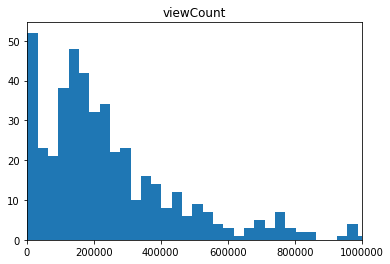

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('jarujaru_data.csv')
plt.hist(df['viewCount'], bins=200)
plt.title('viewCount')
plt.xlim([0, 1000000])
plt.show()

In [3]:
import re
import pandas as pd
info = []
df = pd.read_csv('data/jarujaru_data.csv')
for row, item in df.iterrows():
    if '『' in item['title']:
        title = 'x' + item['title']
        title = re.split('[『』]', title)[1]
        if item['viewCount'] >= 200000:
            label = 2
        elif 100000 <= item['viewCount'] < 200000:
            label = 1
        elif item['viewCount'] < 100000:
            label = 0
        info.extend([[title, item['viewCount'], item['likeCount'], item['dislikeCount'], item['commentCount'], label]])
        
pd.DataFrame(info, columns=['title', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'label']).to_csv('data/jarujaru_norm.csv')

In [2]:
import analysis
import pandas as pd

df = pd.read_csv('data/jarujaru_norm.csv')
words = analysis.get_words(df['title'])
print(words)

[['タイトル', '曲', 'バランス', '合っ', 'て', '奴'], ['なん', 'ミス', 'する', '言う', 'コーチ', '奴'], ['優勝', 'インタビュー', 'ー', '言う', '奴'], ['サウナ', '入る', '南', '奴'], ['変', '先生', '奴'], ['息子', '手紙', '泣か', '奴'], ['屁', '振動', '文字', '書く', '奴'], ['言わ', '奴'], ['珍しい', '形', '会社', '乗っ取る', '奴'], ['オレオレ', '詐欺', '電話', 'かかっ', 'くる', '南', '奴'], ['日本人', 'ー', 'い', '言う', '奴'], ['一', '人', '言', '銀行', '強盗', '説得', 'する', '奴'], ['深呼吸', '吐く', '量', '少ない', '奴'], ['足', 'ぼ', 'マッサージ', 'する', '南', '奴'], ['服', '屋', 'バーベキュー', 'し', '奴'], ['オーダー', 'ミス', '体', '固まる', '奴'], ['拾っ', '財布', 'サイン', 'する', '舞台', '俳優', '奴'], ['ボディービルダー', 'おちょくる', '会社', '立ち', '上げ', '奴'], ['ケンカ', 'する', 'ない', '奴'], ['昔', 'そいつ', 'シバ', 'かれ', '奴'], ['本番', '声', '震える', '奴'], ['分かり', '言う', '分かっ', 'て', '奴'], ['強豪', 'サッカー', '部', '新任', 'コーチ', '奴'], ['笑っ', 'てる', '客', 'セコ', 'い', '言う', '漫才', '師', '奴'], ['客', 'もの', '欲し', 'がる', '引っ越し', '業者', '奴'], ['スカウト', 'さ', 'れ', '大学', '就職', '先', 'やめる', '奴'], ['主婦', 'ボクサー', '密着', 'する', '奴'], ['怒鳴る', 'タイミング', '予想', 'する', '奴'], ['主婦', 'ボクサー', '脱サラ', '５', '０', '

In [3]:
from gensim import corpora

dictionary = corpora.Dictionary(words)
dictionary.filter_extremes()
#dictionary.save_as_text("./tmp/dictionary.txt") で、作成した辞書を保存可能
#dictionary = corpora.Dictionary.load_from_text("./tmp/dictionary.txt") で読み込み
#courpus = [dictionary.doc2bow(word) for word in words]
#print(courpus)

In [6]:
from gensim import matutils

def vec2dense(vec, num_terms):
    return list(matutils.corpus2dense([vec], num_terms=num_terms).T[0])
data_all = [vec2dense(dictionary.doc2bow(words[i]),len(dictionary)) for i in range(len(words))]
#print(data_all)

In [7]:
import numpy as np

target_vector = df['label']
n_labels = len(np.unique(target_vector))
labels = np.eye(n_labels)[target_vector]
print(labels[8])

[0. 0. 1.]


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

#トレーニング・テストデータの設定
train_data = data_all
X_train, X_test, y_train, y_test = train_test_split(train_data, df['label'], test_size=0.4, random_state=1)
print(np.array(X_train).shape)
print(np.array(y_train).shape)

#データの標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


#学習モデルの作成
clf = SVC(C = 3, kernel = 'rbf')
clf.fit(X_train_std, y_train)

(271, 50)
(271,)


SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
score = clf.score(X_test_std, y_test)
print("{:.3g}".format(score))

0.533
